In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
import random
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

list_of_action = {
    0: (0,0),
    1: (0,1),
    2: (0,2),
    3: (1,0),
    4: (1,1),
    5: (1,2),
    6: (2,0),
    7: (2,1),
    8: (2,2)
}

rev_action = {
    (0,0) :0,
    (0,1) :1,
    (0,2) :2,
    (1,0) :3,
    (1,1) :4,
    (1,2) :5,
    (2,0) :6,
    (2,1) :7,
    (2,2) :8
}

In [3]:
def find_aval_actions(state_of_game,act):
  possible_actions = []
  for i in range(9):
    if state_of_game[act[i]] == 0:
      possible_actions.append(i)
  return possible_actions

In [4]:
class DQN(nn.Module):

    def __init__(self, in_features, outputs, action_list):
        super(DQN, self).__init__()
        
        self.action_list = action_list
        #print('input size',in_features )
        
        
        self.head1 = nn.Linear(in_features, 128)
        self.head2 = nn.Linear(128,128)
        self.outputlayer = nn.Linear(128,outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        #print('input x', x.shape, type(x))
        #print('x reshape',x.reshape(x.shape(0),-1))
        Batch_size,_,_,_ = x.shape
        
        #print('x reshape',x.reshape(Batch_size,-1).shape)
        
        x = F.relu(self.head1(torch.Tensor(x).reshape(Batch_size,-1)))
        x = F.relu(self.head2(x))
        x = self.outputlayer(x)
        
        return x
    
    def act(self, state):
        state_tensor = torch.as_tensor(state, dtype=torch.float32)
        #print('----------------------------------------------------------')
        #print('act', state_tensor.shape, state_tensor.unsqueeze(-1).shape )
        q_values = self.forward(state_tensor.unsqueeze(0))
        #possible_q_values = mask_possible_action*q_values
        #print('possible_q_values',possible_q_values)
        
        
        max_q_idx = torch.argmax(q_values, dim=1)[0]
        max_q_idx_item = max_q_idx.detach().item()
        #print('max_q_idx_item', max_q_idx_item, type(max_q_idx_item))
        #print('action list', self.action_list)
        #print('rev_action',rev_action)
        move = self.action_list[max_q_idx_item]
        
        action_idx = rev_action[move]
        
        return action_idx
    
        

In [5]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE_FREQ = 500

number_of_actions = 9
state_features = 18


env = TictactoeEnv()
replay_buffer = deque(maxlen=BUFFER_SIZE)
rew_buffer = deque([0.0], maxlen=10)

episode_reward = 0.0

#initialization network
policy_net = DQN(state_features, number_of_actions,list_of_action).to("cpu")
target_net = DQN(state_features, number_of_actions,list_of_action).to("cpu")
target_net.load_state_dict(policy_net.state_dict())
#target_net.eval()





<All keys matched successfully>

In [6]:
def setup_state(grid, agent_tag):
    #print('Player',agent_tag,'grid',grid)
    #print('grid', type(grid))
    grid_tensor = torch.as_tensor(grid, dtype=torch.float32)
    x_state = torch.zeros((3,3,2))
    if agent_tag == 'X':
        x_state[:,:,0] = torch.eq(grid_tensor,1).int()
        x_state[:,:,1] = torch.eq(grid_tensor,-1).int()
    else:
        x_state[:,:,0] = torch.eq(grid_tensor,-1).int()
        x_state[:,:,1] = torch.eq(grid_tensor,1).int()
    
    #print('agent', x_state[:,:,0])
    #print('opponent',x_state[:,:,1])
    x_state_array = x_state.numpy()
    return x_state_array
    

In [7]:
Turns = np.array(['X','O'])
MIN_REPLAY_SIZE = 10000

#Initialize the Replay Buffer
replay_buffer = deque(maxlen=BUFFER_SIZE)

games = 0
episode_reward = 0.0

while(len(replay_buffer) < BATCH_SIZE):

    env.reset()
    #env.render()
    player1 = "X"
    player2 = "O"
    
    if games%2 == 0:
        player_opt = OptimalPlayer(epsilon = 1., player = player2)
        player_rnd = OptimalPlayer(epsilon = 1., player = player1)
        
    if games%2 == 1:

        #change the state by *-1 when optimal player is X
        player_opt = OptimalPlayer(epsilon = 0.5, player = player1)
        player_rnd = OptimalPlayer(epsilon = 1., player = player2)
        grid, _, __ = env.observe()
        comp_move = player_opt.act(grid)
        env.step(comp_move)
    

    
    for j in range(5):

       
        #random agent play
        obs = env.observe()[0]
        state = setup_state(obs,player_rnd.player)
        move = player_rnd.act(obs)
        grid, end, winner = env.step(move, print_grid=False)
        action = rev_action[move]
        #print('action', action
        
        
        if not end:
            #optimal player play
            move = player_opt.act(grid)
            grid, end, winner = env.step(move, print_grid=False)

        
        new_obs = env.observe()[0]
        new_state = setup_state(new_obs,player_rnd.player)
       
    
        #transition set-off
        rew = env.reward(player=Turns[1])
        transition = (state, action, rew, end, new_state)
        #print('transition', transition)
        replay_buffer.append(transition)
           
        print('games', games, 'buffer', len(replay_buffer))
        games += 1
        
        if end:
            #print('-------------------------------------------')
            #print('Game end, winner is player ' + str(winner))
            #print('Optimal player = ' +  Turns[0])
            #print('Random player = ' +  Turns[1])
            #env.render()
            env.reset()
            break




#for _ in range(MIN_REPLAY_SIZE):
    
   

games 0 buffer 1
games 1 buffer 2
games 2 buffer 3
games 3 buffer 4
games 4 buffer 5
games 5 buffer 6
games 6 buffer 7
games 7 buffer 8
games 8 buffer 9
games 9 buffer 10
games 10 buffer 11
games 11 buffer 12
games 12 buffer 13
games 13 buffer 14
games 14 buffer 15
games 15 buffer 16
games 16 buffer 17
games 17 buffer 18
games 18 buffer 19
games 19 buffer 20
games 20 buffer 21
games 21 buffer 22
games 22 buffer 23
games 23 buffer 24
games 24 buffer 25
games 25 buffer 26
games 26 buffer 27
games 27 buffer 28
games 28 buffer 29
games 29 buffer 30
games 30 buffer 31
games 31 buffer 32
games 32 buffer 33
games 33 buffer 34
games 34 buffer 35
games 35 buffer 36
games 36 buffer 37
games 37 buffer 38
games 38 buffer 39
games 39 buffer 40
games 40 buffer 41
games 41 buffer 42
games 42 buffer 43
games 43 buffer 44
games 44 buffer 45
games 45 buffer 46
games 46 buffer 47
games 47 buffer 48
games 48 buffer 49
games 49 buffer 50
games 50 buffer 51
games 51 buffer 52
games 52 buffer 53
games 53 buf

In [10]:
print(len(replay_buffer))

10000


In [8]:
#Main Training Loop
M_val = []

Nwin = 0
Nlos = 0

player1 = "X"
player2 = "O"

env.reset()
env.render()
player_opt = OptimalPlayer(epsilon=0, player='O')


optimizer = torch.optim.Adam(policy_net.parameters(), lr=5e-4)
rew_buffer = deque([0.0], maxlen=100)
reward_memory =[]
bad_pred_buffer = deque([0.0], maxlen=100)
random_buffer = deque([0.0], maxlen=100)

loss_buffer = deque([0.0], maxlen=100)

game = 0
old_game = 0
step = 0
bad_prediction = False

episode_reward = 0.0
episode_bad_predict = 0.0
episode_random = 0.0

criterion = torch.nn.HuberLoss(delta=1.0)

new_game = True
while(game < 20000):
    step +=1
    epsilon = np.interp(step, [0, EPS_DECAY], [EPS_START,EPS_END])
    
    
    if new_game:
        new_game = False
        if games%2 == 0:
            player_opt = OptimalPlayer(epsilon = 0, player = player2)
            agent_tag =  player1
        
        if games%2 == 1:
            #change the state by *-1 when optimal player is X
            player_opt = OptimalPlayer(epsilon = 0, player = player1)
            agent_tag = player2
            grid, _, __ = env.observe()
            comp_move = player_opt.act(grid)
            env.step(comp_move)
        
    
   
    #random agent play
    rnd_sample = random.random()
    obs = env.observe()[0]
    state = setup_state(obs,agent_tag)
    available_action = find_aval_actions(obs, list_of_action)
    if rnd_sample <= epsilon:
        random_int = random.randint(0,len(available_action)-1)
        #print('random_int', random_int, 'len available action',len(available_action))
        move = available_action[random_int]
        #print('move',move)
        episode_random +=1
    else:
        move = policy_net.act(state)
        #print('move',move)
    
    
    
    if not move in available_action:
        #print(' bad prediction', available_action)
        bad_prediction = True
        
    
    
    if not bad_prediction:
        #print('env step')
        grid, end, winner = env.step(move, print_grid=False)
        #env.render()
        
    action = move
    #print('###### action #####',action)
    #env.render()
    
    if (not end) and (not bad_prediction):
        #optimal player play
        move = player_opt.act(grid)
        #print('optimal move', move)
        
        grid, end, winner = env.step(move, print_grid=False)
        #env.render()
    

    #transition set-off
    new_obs = env.observe()[0]
    new_state = setup_state(new_obs,agent_tag)
    if not bad_prediction:
        rew = env.reward(player='X')
        transition = (state, action, rew, end, new_state)
    else:
        rew = -1
        transition = (state, action, rew, True, new_state)
        #end = False
    
    #print('transition', transition)
    replay_buffer.append(transition)
    
    
    if end or bad_prediction:
        new_game = True
        #print('game finish')
        if bad_prediction:
            episode_bad_predict += 1
            Nlos += 1 
        
        if rew == 1:
            Nwin += 1
            
        if game % 500 == 0:
            M_val.append((Nwin-Nlos)/500)
            Nwin = 0
            Nlos = 0
            
            
        bad_prediction = False
        #print('-------------------------------------------')
        #print('Game end, winner is player ' + str(winner))
        #print('Optimal player = ' +  Turns[0])
        #print('Random player = ' +  Turns[1])
        #env.render()
        env.reset()
        episode_reward += rew
        game += 1
        if game % 10 == 0:
            
            loss_buffer.append(loss.detach().numpy())
            rew_buffer.append(episode_reward)
            bad_pred_buffer.append(episode_bad_predict)
            random_buffer.append(episode_random)

            # Logging
            if game % 100 == 0:
                reward_memory.append(np.mean(rew_buffer))
                print()
                print('game', game)
                print('episode random',episode_random)
                print('Avg random', np.mean(random_buffer))
                print('episode bad predi',episode_bad_predict)
                print('Avg bad predi', np.mean(bad_pred_buffer))
                print('episode rew',episode_reward)
                print('Avg Rew', np.mean(rew_buffer)) 
                print('Loss', loss)
            episode_reward = 0.0
            episode_bad_predict = 0.0
            episode_random = 0.0
    
    
    # Start Gradient Step
    #print('replay_buffer', len(replay_buffer))
    transitions = random.sample(replay_buffer, BATCH_SIZE)
    
    obses = np.asarray([t[0] for t in transitions])
    #print('obses', type(obses))
    #print(obses)
    actions = np.asarray([t[1] for t in transitions])
    #print('actions type', type(actions))
    #print(actions)
    rews = np.asarray([t[2] for t in transitions])
    dones = np.asarray([t[3] for t in transitions])
    new_obses = np.asarray([t[4] for t in transitions])
    
    obses_tensor = torch.as_tensor(obses, dtype=torch.float32)
    actions_tensor = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
    rews_tensor = torch.as_tensor(rews, dtype=torch.float32).unsqueeze(-1)
    dones_tensor = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
    new_obses_tensor = torch.as_tensor(new_obses, dtype=torch.float32)
    
    #print('obses_tensor', obses_tensor.shape)
    #print('new_obses_tensor', new_obses_tensor.shape)
    
    # Compute Targets
    target_q_values = target_net(new_obses_tensor)
    #print('target_q_values',target_q_values.shape)
    #mask_possible_action = torch.ne(new_obses_tensor,0)*-1
    #print('mask_possible_action',mask_possible_action.shape)
    #possible_target_q_values = target_q_values * mask_possible_action
    #print('possible_target_q_values',possible_target_q_values.shape)
    max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
    #print('max_target_q_values', max_target_q_values.shape)
    
    targets = rews_tensor + GAMMA * ( 1 - dones_tensor)  * max_target_q_values
    
    
    
    # Compute Loss
    
    q_values = policy_net(obses_tensor)
    
    
    # give the q values of the action we took
    action_q_values = torch.gather(input=q_values, dim=1, index=actions_tensor)
    
#     print('action_q_values',action_q_values.shape, 'targets',targets.shape)
#     print('actions_tensor', actions_tensor[0], actions_tensor[1])
#     print('q_values', q_values[0])
#     print('q_values row 1', q_values[1])
#     print('action_q_values',action_q_values[0])
    
    #loss = nn.functional.smooth_l1_loss(q_values_max, targets)
    loss = criterion(action_q_values, targets)
   
    
    #print('loss', loss, loss.shape, type(loss))
#     max_q_idx = torch.argmax(possible_q_values, dim=1)[0]
#     max_q_idx_item = max_q_idx.detach().item()
    
    
    # Gradient Descent
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Update Target Network
    if step % TARGET_UPDATE_FREQ == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
    # Logging
    


|- - -|
|- - -|
|- - -|


game 100
episode random 2.0
Avg random 8.727272727272727
episode bad predi 6.0
Avg bad predi 5.0
episode rew -7.0
Avg Rew -8.454545454545455
Loss tensor(0.0052, grad_fn=<HuberLossBackward0>)

game 200
episode random 6.0
Avg random 5.904761904761905
episode bad predi 2.0
Avg bad predi 4.190476190476191
episode rew -6.0
Avg Rew -6.904761904761905
Loss tensor(0.0021, grad_fn=<HuberLossBackward0>)

game 300
episode random 2.0
Avg random 4.709677419354839
episode bad predi 7.0
Avg bad predi 4.516129032258065
episode rew -9.0
Avg Rew -7.096774193548387
Loss tensor(0.0038, grad_fn=<HuberLossBackward0>)

game 400
episode random 2.0
Avg random 4.0
episode bad predi 7.0
Avg bad predi 4.341463414634147
episode rew -10.0
Avg Rew -7.7317073170731705
Loss tensor(0.0084, grad_fn=<HuberLossBackward0>)

game 500
episode random 1.0
Avg random 3.5098039215686274
episode bad predi 1.0
Avg bad predi 3.843137254901961
episode rew -6.0
Avg Rew -7.666666666666667
Loss tensor(0.0313, 


game 4800
episode random 4.0
Avg random 2.6
episode bad predi 0.0
Avg bad predi 0.08
episode rew -1.0
Avg Rew -0.59
Loss tensor(0.0014, grad_fn=<HuberLossBackward0>)

game 4900
episode random 2.0
Avg random 2.5
episode bad predi 0.0
Avg bad predi 0.07
episode rew 0.0
Avg Rew -0.61
Loss tensor(1.0949e-05, grad_fn=<HuberLossBackward0>)

game 5000
episode random 0.0
Avg random 2.48
episode bad predi 0.0
Avg bad predi 0.1
episode rew 0.0
Avg Rew -0.65
Loss tensor(1.4346e-05, grad_fn=<HuberLossBackward0>)

game 5100
episode random 2.0
Avg random 2.39
episode bad predi 0.0
Avg bad predi 0.17
episode rew 0.0
Avg Rew -0.82
Loss tensor(0.0002, grad_fn=<HuberLossBackward0>)

game 5200
episode random 3.0
Avg random 2.45
episode bad predi 0.0
Avg bad predi 0.17
episode rew -1.0
Avg Rew -0.82
Loss tensor(5.0858e-05, grad_fn=<HuberLossBackward0>)

game 5300
episode random 1.0
Avg random 2.37
episode bad predi 0.0
Avg bad predi 0.17
episode rew 0.0
Avg Rew -0.81
Loss tensor(0.0003, grad_fn=<HuberLos


game 9700
episode random 3.0
Avg random 2.41
episode bad predi 0.0
Avg bad predi 0.09
episode rew 0.0
Avg Rew -0.72
Loss tensor(0.0006, grad_fn=<HuberLossBackward0>)

game 9800
episode random 3.0
Avg random 2.47
episode bad predi 0.0
Avg bad predi 0.09
episode rew 0.0
Avg Rew -0.71
Loss tensor(0.0003, grad_fn=<HuberLossBackward0>)

game 9900
episode random 1.0
Avg random 2.46
episode bad predi 0.0
Avg bad predi 0.08
episode rew 0.0
Avg Rew -0.7
Loss tensor(0.0003, grad_fn=<HuberLossBackward0>)

game 10000
episode random 4.0
Avg random 2.4
episode bad predi 1.0
Avg bad predi 0.09
episode rew -1.0
Avg Rew -0.67
Loss tensor(1.0544e-05, grad_fn=<HuberLossBackward0>)

game 10100
episode random 3.0
Avg random 2.46
episode bad predi 0.0
Avg bad predi 0.08
episode rew 0.0
Avg Rew -0.65
Loss tensor(1.5095e-05, grad_fn=<HuberLossBackward0>)

game 10200
episode random 1.0
Avg random 2.34
episode bad predi 0.0
Avg bad predi 0.08
episode rew 0.0
Avg Rew -0.63
Loss tensor(6.7777e-06, grad_fn=<Huber


game 14500
episode random 2.0
Avg random 2.61
episode bad predi 0.0
Avg bad predi 0.12
episode rew 0.0
Avg Rew -0.66
Loss tensor(5.4186e-05, grad_fn=<HuberLossBackward0>)

game 14600
episode random 1.0
Avg random 2.56
episode bad predi 0.0
Avg bad predi 0.09
episode rew 0.0
Avg Rew -0.66
Loss tensor(6.2423e-06, grad_fn=<HuberLossBackward0>)

game 14700
episode random 1.0
Avg random 2.53
episode bad predi 0.0
Avg bad predi 0.09
episode rew 0.0
Avg Rew -0.62
Loss tensor(3.1732e-05, grad_fn=<HuberLossBackward0>)

game 14800
episode random 2.0
Avg random 2.57
episode bad predi 0.0
Avg bad predi 0.09
episode rew 0.0
Avg Rew -0.62
Loss tensor(1.1998e-05, grad_fn=<HuberLossBackward0>)

game 14900
episode random 3.0
Avg random 2.68
episode bad predi 0.0
Avg bad predi 0.09
episode rew -1.0
Avg Rew -0.65
Loss tensor(2.5686e-05, grad_fn=<HuberLossBackward0>)

game 15000
episode random 6.0
Avg random 2.66
episode bad predi 0.0
Avg bad predi 0.09
episode rew -1.0
Avg Rew -0.65
Loss tensor(5.8567e-


game 19300
episode random 3.0
Avg random 2.55
episode bad predi 0.0
Avg bad predi 0.03
episode rew -1.0
Avg Rew -0.55
Loss tensor(4.5577e-06, grad_fn=<HuberLossBackward0>)

game 19400
episode random 2.0
Avg random 2.46
episode bad predi 0.0
Avg bad predi 0.04
episode rew -1.0
Avg Rew -0.54
Loss tensor(3.2647e-06, grad_fn=<HuberLossBackward0>)

game 19500
episode random 3.0
Avg random 2.49
episode bad predi 0.0
Avg bad predi 0.04
episode rew -1.0
Avg Rew -0.48
Loss tensor(6.0110e-06, grad_fn=<HuberLossBackward0>)

game 19600
episode random 2.0
Avg random 2.52
episode bad predi 0.0
Avg bad predi 0.05
episode rew -1.0
Avg Rew -0.47
Loss tensor(2.8232e-05, grad_fn=<HuberLossBackward0>)

game 19700
episode random 3.0
Avg random 2.59
episode bad predi 0.0
Avg bad predi 0.03
episode rew 0.0
Avg Rew -0.52
Loss tensor(8.0276e-06, grad_fn=<HuberLossBackward0>)

game 19800
episode random 2.0
Avg random 2.55
episode bad predi 0.0
Avg bad predi 0.03
episode rew -1.0
Avg Rew -0.53
Loss tensor(6.377

In [9]:
M_rand = []
M_rand = M_val

In [20]:
len(M_rand)

40

In [11]:
M_opt = []
M_opt = M_val

In [32]:
len(M_opt)

40

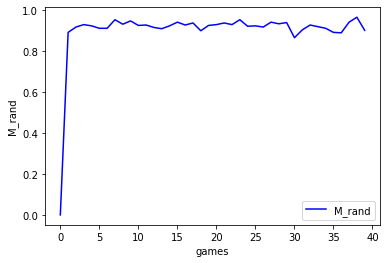

In [33]:
plt.plot(M_rand, color='b', label='M_rand')
plt.ylabel('M_rand')
plt.xlabel('games')
plt.legend()
plt.show()

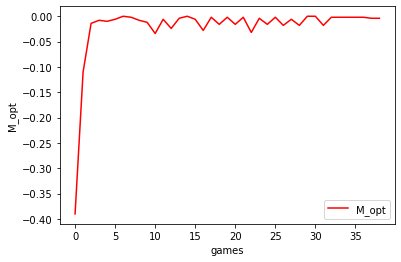

In [12]:
plt.plot(M_opt[1:], color='r', label='M_opt')
plt.ylabel('M_opt')
plt.xlabel('games')
plt.legend()
plt.show()

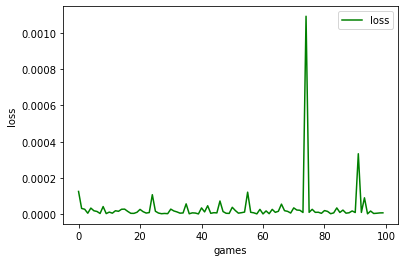

In [13]:
plt.plot(loss_buffer, color='g', label='loss')
plt.ylabel('loss')
plt.xlabel('games')
plt.legend()
plt.show()

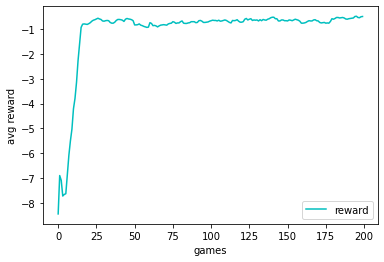

In [14]:
plt.plot(reward_memory, color='c', label='reward')
plt.ylabel('avg reward')
plt.xlabel('games')
plt.legend()
plt.show()